I am assuming detectors are placed in vertical straight line configuration and the total detector array width is 10cm.
gap = 10/32
In this code, I am considering the object centre to be the origin, not the source.

In [1]:
import decimal
decimal.getcontext().prec = 10

gap = 10/32
gap

0.3125

Taking input.

In [2]:
source_object = float(input('enter source to object distance:'))
num_pixels = int(input('Fill in the object size: '))
source_detector = float(input('enter source to detector distance: '))
num_detectors = int(input('enter no. of detectors:'))
num_rotations = int(input('enter no. of rotations: '))

In [3]:
import numpy as np
import matplotlib.pyplot as plt

Finding the A matrix by calculating the intercept length.

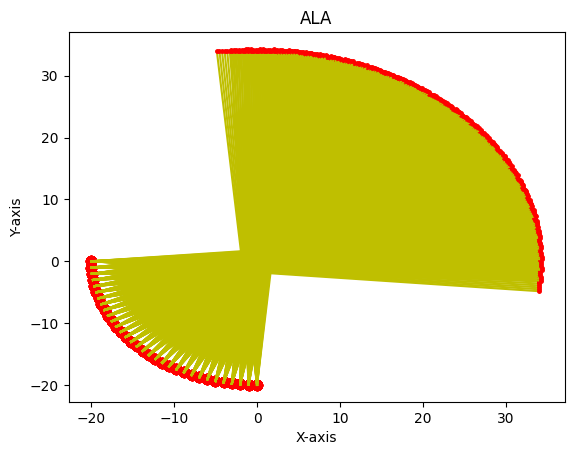

In [4]:
theta = np.linspace(0, np.pi/2, num_rotations)
matrix_A = np.zeros((num_detectors*num_rotations, num_pixels*num_pixels))

row =0
source_dist = source_object
for i in range(num_rotations):
    angle = theta[i]
    
    #source coodinates
    source_x = -source_dist * np.cos(angle)
    source_y = -source_dist * np.sin(angle)
    
    #detector coordinates
    det_dist = source_detector - source_dist + num_pixels
    detector_x = det_dist * np.cos(angle)
    detector_y = det_dist * np.sin(angle)
    theta_detector_line = angle + (np.pi/2)
    
    for i in range(num_detectors):
        j = i - (num_detectors-1)/2
        x_detector_j = detector_x + (j*gap) * np.cos(theta_detector_line)
        y_detector_j = detector_y + (j*gap) * np.sin(theta_detector_line)

        plt.plot([source_x, x_detector_j ], [source_y, y_detector_j ], 'y-')
        plt.plot(x_detector_j , y_detector_j , 'r.', markersize=5)
        plt.scatter(source_x, source_y, color='red', marker='o', s=50)
        plt.xlabel('X-axis')
        plt.ylabel('Y-axis')
        plt.title('ALA')
        plt.grid() 

        
        #line parameters
        m = (y_detector_j - source_y) / (x_detector_j  - source_x)
        c = y_detector_j  - x_detector_j * m
        col = 0
        
        for x_0 in range(-(num_pixels-1)//2, (num_pixels-1)//2 + 1):
            for y_0 in range(-(num_pixels-1)//2, (num_pixels-1)//2 + 1):
                y_1 = m * (x_0 - 0.5) + c
                y_2 = m * (x_0 + 0.5) + c
                
                if y_1 > y_2:
                    y_1, y_2 = y_2, y_1

                if y_1 > y_0 + 0.5 or y_2 < y_0 - 0.5:
                    y_int = 0
                    intercept_length = 0
                else:
                    y_int = min(y_2, y_0 + 0.5) - max(y_1, y_0 - 0.5)
                    x_1 = ((y_0 - 0.5) - c) / m
                    x_2 = ((y_0 + 0.5) - c) / m
                    
                    if x_2 < x_0 - 0.5 or x_1 > x_0 + 0.5:
                        intercept_length = 0
                    else:
                        x_int = min(x_0 + 0.5, x_2) - max(x_0 - 0.5, x_1)
                        intercept_length = np.sqrt(x_int*2 + y_int*2)
                        
                matrix_A[row, col] = intercept_length
                col += 1
        row += 1

In [5]:
matrix_A.shape

(1024, 144)

In [6]:
non_zero_count = np.count_nonzero(matrix_A)
print(f"non_zero_count: {non_zero_count}")
zero_count = np.size(matrix_A) - np.count_nonzero(matrix_A)
print(f"zero count: {zero_count}")

non_zero_count: 16986
zero count: 130470


In [7]:
# Specify the file path
import re
file_path = "/Users/bhumitarora/Downloads/ALA/projection_data_phantom.dat"

# Open the file in read mode ("r")
with open(file_path, "r") as file:
    # Read the entire content of the file into a string
    file_contents = file.read()


# Now, you can work with the contents of the file
b = np.array([float(x) for x in re.split(',|\n', file_contents) if x], dtype=np.float64)

print(b)


[0.         0.42842043 0.33517464 ... 0.5536513  0.29174014 0.42842043]


In [16]:
def gauss_jordan_elimination(A, b):
    dim = np.shape(A)
    m = dim[0]
    n = dim[1]
    augmented_matrix = np.hstack((A,b)).astype(np.float64)
    if (m < n) :
        print("No unique solution as it is underdetermined system")
        return None
    for i in range(n):
        pivot_row = i
        for j in range(i, m):
            if abs(augmented_matrix[j, i]) > abs(augmented_matrix[pivot_row, i]):
                pivot_row = j
        augmented_matrix[i, :], augmented_matrix[pivot_row, :] = augmented_matrix[pivot_row, :], augmented_matrix[i, :] #Exchanging rows
        if augmented_matrix[i, i] == 0 :
            print("No unique solution through Gauss-Jordan elimination")
            return None
        augmented_matrix[i, :] /= augmented_matrix[i][i] #scaling by 1
        for j in range(m):
            if (j == i) :
                continue
            else :
                augmented_matrix[j,:] -= augmented_matrix[i, :]*augmented_matrix[j, i] #elimination
        print(np.round(augmented_matrix))
    for i in range(n, m) :
        if(augmented_matrix[i,n] != 0) :
            print("Inconsistent System")
            return None
    x = np.empty([n])
    for i in range(n):
        x[i] = augmented_matrix[i,n]
    print(x)
    return x

Finding A^-1

In [8]:
b_reshaped = b.reshape([num_rotations*num_detectors,1])
pseudoinverse_A = np.linalg.pinv(matrix_A)
pseudoinverse_A.shape

(144, 1024)

Finding A^-1 * b

In [9]:
matrix_X = np.dot(pseudoinverse_A,b_reshaped)
matrix_X.shape

(144, 1)

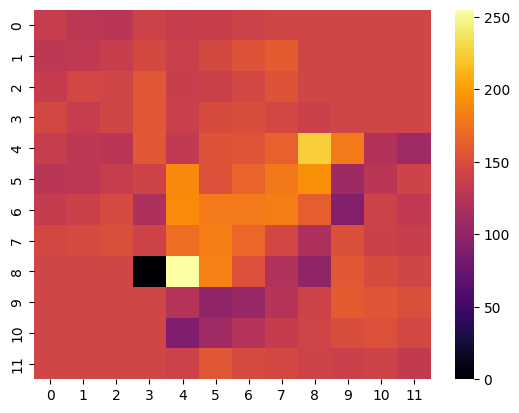

array([[135.09479736, 128.29342787, 126.51144149, 140.33156638,
        134.84424145, 137.08781258, 139.90457536, 142.96452443,
        143.33924023, 143.33924023, 143.33924023, 143.33924023],
       [129.15286893, 130.23971383, 136.42669131, 145.75799567,
        138.28166705, 146.13569882, 154.33402365, 160.07807827,
        143.33924023, 143.33924023, 143.33924023, 143.33924023],
       [134.03380417, 143.68572204, 143.21665808, 156.6373827 ,
        135.86344204, 139.11246034, 143.9331732 , 154.10089131,
        143.33924023, 143.33924023, 143.33924023, 143.33924023],
       [144.88060164, 135.22992316, 142.53986845, 156.90883347,
        138.33572708, 148.40088869, 149.94762625, 143.79454523,
        139.41823969, 143.33924023, 143.33924023, 143.33924023],
       [134.48043871, 129.05585321, 127.38342867, 157.56372764,
        130.53179785, 154.24290584, 154.69945139, 163.86412124,
        225.68069926, 180.06473843, 121.74074015, 110.09471127],
       [126.65753053, 127.68143104,

In [10]:
import seaborn as sns

scaled_X = (matrix_X - matrix_X.min()) / (matrix_X.max() - matrix_X.min())
scaled_X = scaled_X * 255 
X = np.reshape(scaled_X, (num_pixels, num_pixels))
custom_cmap = sns.color_palette("inferno", as_cmap=True)
sns.heatmap(X,cmap= custom_cmap)
plt.show()
X

In [11]:
from PIL import Image
image = Image.fromarray(X)
image.show()

Compressing the original image into the dimensions of our matrix A^-1 * b.

In [12]:
# Open the original TIFF image
original_image = Image.open("/Users/bhumitarora/Downloads/ALA/projection_data_phantom.tiff")  # Replace with the path to your TIFF image

# Resize the image to (12, 12) pixels using the thumbnail method
compressed_image = original_image.resize(X.shape)

# Save the compressed image as TIFF
compressed_image.save("compressed_image_phantom_projectiondata.tiff")  # Replace with your desired output file name and format

# Close the image objects
original_image.close()
compressed_image.close()





In [13]:

# Open an image file
image_path = "/Users/bhumitarora/Downloads/ALA/compressed_image_phantom_projectiondata.tiff"  # Replace with the path to your image file
image = Image.open(image_path).convert("L")

# Get the width and height of the image
width, height = image.size

# Access pixel values
pixels1 = np.array(image)
pixels1.shape

(12, 12)

In [14]:


# Calculate the squared differences between corresponding pixels
squared_diff = (pixels1 - X) ** 2

# Calculate the Mean Squared Error (MSE)
mse = np.mean(squared_diff)

rmse = np.sqrt(mse)
rmse

71.84572758521139

In [15]:
percentage_error = (rmse / 255.0) * 100.0  # Assuming 8-bit grayscale images (0-255 range)

print("Percentage Error based on RMSE:", percentage_error, "%")

Percentage Error based on RMSE: 28.17479513145545 %
